# Polynomial Model Testing

The purpose of this notbook is to examine the relationship (or lack thereof) between drug's various features by creating interaction terms. This would would hopefully show that there is a strong relationship between aggregate drug markers and their method of action in order to create a more accurate model.

In [67]:
import io, requests

import datetime
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import xgboost as xgb

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import NuSVR
from sklearn.metrics import log_loss

###############################################################################
# Undersampling did not show any appreciable improvement in model performance #
###############################################################################

# from imblearn.under_sampling import TomekLinks # removed 5ish samples and only made a marginal improvement to the logloss values
# from imblearn.under_sampling import ClusterCentroids # wasn't useful
# from imblearn.under_sampling import NeighbourhoodCleaningRule # made model marginally worse and took significantly longer
# from imblearn.under_sampling import InstanceHardnessThreshold #kept getting errors
# from imblearn.under_sampling import EditedNearestNeighbours#did not remove any samples
# from imblearn.under_sampling import AllKNN#did not remove any samples
# from imblearn.under_sampling import CondensedNearestNeighbour#crashed after using all ram
# from imblearn.under_sampling import NearMiss# marginally worse after running NearMiss(version=2, n_jobs=2, sampling_strategy=sampling_val)

## Loading the data

In [2]:
def dummy_vars(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    # trt_cp is a control and has no MOA, ctl_vehicle indicates a real test
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    # create columns ['cp_type_24', 'cp_type_48', 'cp_type_72'] which are one hot encoded based on cp_time
    df['cp_type_24'] = df['cp_time'].astype(str) == '24'
    df['cp_type_48'] = df['cp_time'].astype(str) == '48'
    df['cp_type_72'] = df['cp_time'].astype(str) == '72'
    df.drop(columns=['sig_id','cp_time'], inplace = True)
    return df

In [3]:
def load_files():
    # Train Features
    train_features = pd.read_csv('train_features.csv')
    train_features = dummy_vars(train_features)
    print('train_features loaded')

    # Train Targets
    train_targets = pd.read_csv('train_targets_scored.csv')
    train_targets.drop(columns=['sig_id'], inplace = True)
    print('train_targets loaded')

    # Test Features
    test_features = pd.read_csv('test_features.csv')
    test_features = dummy_vars(test_features)
    #test_features = pd.DataFrame(power_transform(test_features, method='yeo-johnson'))
    print('test_features loaded')

    # Sample Submission DF (Targets)
    ss_lr = pd.read_csv('sample_submission.csv')
    ss_lr.drop(columns=['sig_id'], inplace = True)
    print('ss_lr loaded')

    print('done!')

    return train_features, train_targets, test_features, ss_lr

## Data Processing/Prediction Pipeline

In [4]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

In [131]:
def k_fold_fit_pred(model_train_num, column, x_test, target_vals, N_SPLITS, res, ss, coef_df2):
    for rand_state in range(model_train_num):
        # train the model for each one of the random states 
        skf = StratifiedKFold(n_splits = N_SPLITS, random_state = rand_state, shuffle = True)

        for (train, val) in skf.split(target_vals, target_vals):
        # for each of the train/validate splits...
            
            #print(X[train].shape, end = '\r')
            #print(target_vals[train].shape)
            
            #x_train = X[train, column].reshape(-1, 1).astype(float)
            x_train = X_df.values[train].astype(float)
            y_train = target_vals[train].astype(float)

            x_train = scaler.fit_transform(x_train)

            #x_val = X[val, column].astype(float)#.reshape(-1, 1).astype(float)
            x_val = X_df.values[val].astype(float)
            y_val = target_vals[val].astype(float)

            x_val = scaler.transform(x_val)

            model.fit(x_train, y_train)
            temp_df = pd.DataFrame([list(model.coef_)], columns = list(X_df.columns))
            #print(temp_df.head())
            coef_df = pd.concat([coef_df2,temp_df])
            #print(coef_df.head())
            
            try:
                ss_pred_vals = model.predict_proba(x_test[:, column].reshape(-1,1))[:,1]
            except: # For the tree based models
                #ss_pred_vals = model.predict(x_test[:, column].reshape(-1,1))
                ss_pred_vals = model.predict(x_test)
            ss.loc[:, train_targets.columns[column]] += (
                ss_pred_vals / (N_SPLITS * model_train_num))

            try:
                res_pred_vals = model.predict_proba(x_val)[:,1]
            except: # For the tree based models
                res_pred_vals = model.predict(x_val)
            res.loc[val, train_targets.columns[column]] += (
                res_pred_vals / model_train_num)

    return res, ss, coef_df2

In [124]:
# cols = [c for c in ss_lr.columns.values]
def run_score(train_targets, X_df.values, x_test_df.values, res, ss, logloss_vals, coef_df2):
# train_targets is the training targets
# X is the train features
# x_test is the holdout set of features
# ss_ is blank since it's the empty sample submission predictions

    N_SPLITS = 5 # number of k-fold splits
    model_train_num = 3 # number of random states the model is trained on for each target

    for column in tqdm(range(train_targets.shape[1])):
    # create a model for each of the targets
        start_time = time()
        target_vals = train_targets.values[:, column]

        if target_vals.sum() >= 5:
        # split if there's enough positive target values
            res, ss, coef_df2 = k_fold_fit_pred(model_train_num, column, x_test_df.values, target_vals, N_SPLITS, res, ss, coef_df2)
            
        score = log_loss(
            train_targets.loc[:, train_targets.columns[column]],
            res.loc[:, train_targets.columns[column]])
        feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
        #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
        target_counts.append(np.sum(target_vals))
        logloss_vals.append(score)
        #print(coef_df.head())

    print(f'Log Loss: {log_loss_metric(train_targets, res)}')

    # these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
    res.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
    ss.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
    print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res)}\n\n')
    
    return res, ss, logloss_vals, coef_df2

In [72]:
train_features, train_targets, test_features, ss_lr = load_files()

g_tags = [g for g in list(train_features.columns) if g[0]+g[1] == 'g-']
c_tags = [c for c in list(train_features.columns) if c[0]+c[1] == 'c-']
d_tags = [d for d in list(train_features.columns) if d not in c_tags]
d_tags = [d for d in d_tags if d not in g_tags]

# train_features[c_tags] = scaler.fit_transform(train_features[c_tags])
# test_features[c_tags] = scaler.fit_transform(test_features[c_tags])

# train_features[g_tags] = scaler.fit_transform(train_features[g_tags])
# test_features[g_tags] = scaler.fit_transform(test_features[g_tags])

#X = train_features.values[:,:]
poly = PolynomialFeatures(interaction_only=True)
X = np.concatenate([train_features.loc[:,d_tags].values,
               poly.fit_transform(train_features.loc[:,c_tags]),
               train_features.loc[:,g_tags]],
              axis=1)
#x_test = test_features.values[:,:]
x_test = np.concatenate([test_features.loc[:,d_tags].values,
               poly.fit_transform(test_features.loc[:,c_tags]),
               test_features.loc[:,g_tags].values],
              axis=1)

#This is for the sample_submission.csv df
ss_lr.loc[:, train_targets.columns] = 0

#These are the target values which are being predicted and tested
res_lr = train_targets.copy()
res_lr.loc[:, train_targets.columns] = 0

cols = ss_lr.columns.values

train_features loaded
train_targets loaded
test_features loaded
ss_lr loaded
done!


In [73]:
feat_labels = d_tags + poly.get_feature_names(input_features=c_tags) + g_tags
coef_df = pd.DataFrame(columns = feat_labels)

## Running and Evaluating the Models

The features fall into three distinct groups:
- Chemical Markers (Denoted as c-__)
- Genetic Markers (Denoted as g-__)
- Experimental Variables (Denoted as cp-__)

Based on the varying number of features in each of these categories, chemical marker feature interaction terms were chosen as the first group to explore. This is because there were 100 of these features and the feature space went from 900 terms to ~5500. Looking at the genetic markers would have expanded the feature space significantly beyond that and would have required ~60GB of RAM which makes the model impractical to analyze in a reasonable amount of time while leveraging GPUs.

[W] [10:16:56.339160] QWL-QN: max iterations reached
[W] [11:57:16.705341] QWL-QN: max iterations reached
[W] [11:57:40.893372] QWL-QN: max iterations reached
[W] [11:58:22.589945] QWL-QN: max iterations reached
[W] [11:58:39.623664] QWL-QN: max iterations reached
[W] [11:59:10.205158] QWL-QN: max iterations reached
[W] [11:59:27.273932] QWL-QN: max iterations reached
[W] [11:59:44.365539] QWL-QN: max iterations reached
[W] [12:00:24.288939] QWL-QN: max iterations reached
[W] [12:10:12.110509] QWL-QN: max iterations reached
[W] [12:10:45.550960] QWL-QN: max iterations reached
[W] [12:11:02.447477] QWL-QN: max iterations reached
[W] [12:11:30.649704] QWL-QN: max iterations reached
[W] [12:11:47.772635] QWL-QN: max iterations reached
[W] [12:12:04.915928] QWL-QN: max iterations reached
[W] [12:12:21.861254] QWL-QN: max iterations reached
[W] [13:52:47.169839] QWL-QN: max iterations reached
[W] [13:53:35.720645] QWL-QN: max iterations reached
[W] [13:54:21.895133] QWL-QN: max iterations r

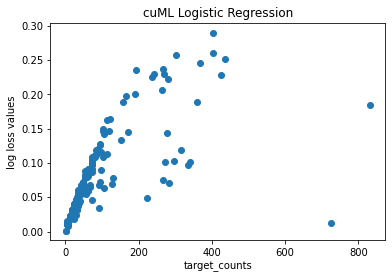

In [76]:
from cuml.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegression

feat_labels = d_tags + poly.get_feature_names(input_features=c_tags) + g_tags
coef_df = pd.DataFrame(columns = feat_labels)

# column_names = ["a", "b", "c"]
# coef_df = pd.DataFrame(columns = column_names)
rowval = 0
for i in [256]: # left for further hyperparameter tuning
    from cuml.experimental.preprocessing import StandardScaler
    scaler = StandardScaler()
    #model = LogisticRegression(C = 128, max_iter = 100000, penalty='elasticnet', l1_ratio=1)
    model = LogisticRegression(C = 128, penalty='elasticnet', l1_ratio=1)
    target_counts = []
    logistic_regr_loss_vals = []
    ss_lr.loc[:, train_targets.columns] = 0
    res_lr.loc[:, train_targets.columns] = 0
    res_lr, ss_lr, logistic_regr_loss_vals, coef_df = run_score(train_targets, X_df.values, x_test_df.values, res_lr, ss_lr, logistic_regr_loss_vals, coef_df)
    
plt.scatter(target_counts,logistic_regr_loss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('cuML Logistic Regression')
plt.show()
res_lr.to_pickle('pickles/res_cuml_lr.p')
ss_lr.to_pickle('pickles/ss_cuml_lr.p')

## Analyzing the Results
- The weights from each of the models (306 targets, 10 per target) were saved into the following dataframe to get an intuition of which features could be correllated positively or negatively with the targets.
- For each of the features the standard deviation and the mean was taken.
- The features which had a low correllation value (mean close to zero) and relatively little deviation from that correllation value were eliminated.
- Using the reduced list of features the model was run again.
- The model with the reduced feature space had a roughly 40% improvement in the loss score.
## Thoughts
Typically a larger feature space would allow a model to perform better as it gives more opportunity for a given algorithm to find paterns in the noise. Since a training penalty was used it makes sense that "pruning" the features which showed a low correllation with the target improved the score by preventing the model from overfitting on the noise in the training set. This process would make sense to repeat as long as the model scores keep improving. After that it would be interesting to see if applying an l2 penalty or no penalty could further improve the model's performance.

In [77]:
coef_df

,cp_type,cp_dose,cp_type_24,cp_type_48,cp_type_72,1,c-0,c-1,c-2,c-3,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,[-0.05545241691160695],[2.1199877096858333],[3.5271482203135216],[3.653198715312279],[0.24798512687284416],[0.99958100092857],[0.3584368250253535],[-0.33353422802050986],[-0.38113551132676826],[0.7091074024443236],...,[0.8749090264333937],[3.9134005806488834],[-0.013360612907235822],[1.998728818097307],[1.1963255070951602],[1.4745708244240772],[0.9484212982815089],[1.2338218095092064],[0.9618653384274806],[1.593447621983805]
0,[0.4508431468627332],[2.873485045489368],[2.9652882798202773],[3.2701409307817215],[3.8364220715811967],[0.9990469869683756],[-0.24276896443051477],[-0.17584555663391227],[-0.09340903850804319],[-0.15055492453984126],...,[1.1234876098069022],[0.9783480523572948],[0.0],[0.6425866206498884],[-0.11338716529274412],[0.5954042392528222],[-0.0367879514866143],[1.4282135378204226],[-0.21471668822199522],[0.4299493304933841]
0,[0.0],[0.5588296295353339],[1.2114260479070598],[2.0293362075683783],[0.9491503528663043],[0.9996118950505938],[0.0],[-0.6937736262063956],[-0.04667038184078219],[-0.5925380500991164],...,[5.788151692534951],[2.7926051300193055],[0.06368329672739806],[1.5946004453286233],[4.913552866965104],[0.19162081412667947],[-0.09844020216902022],[0.6618449783924507],[-0.27918635370739786],[0.4656207367885598]
0,[0.0426137180178707],[0.5504140823396886],[3.7113987675694897],[9.48382957453369],[4.47779354037929],[0.999483124750076],[0.06604431351820879],[-0.24232866670645634],[0.09737170104846313],[0.04854733305685826],...,[-1.731097853854435],[3.816077104419831],[0.015288095598431715],[1.3130385967948641],[2.302586763906089],[2.7182835191329793],[-0.327208491625899],[-0.6626519876377063],[-0.5035431886749584],[0.5250355946095726]
0,[0.24410124395251065],[-0.2176690097060736],[2.9799582306740913],[3.191714050714197],[3.6493622766874414],[0.9998932923168317],[0.06610327255740722],[0.15397887868935686],[0.17268113054416961],[-0.03283548422204124],...,[0.7443678210568891],[3.866481668597004],[-0.07609707814174005],[2.3216025935674516],[1.1900319403529864],[-2.739423235704266],[0.07328868753990539],[1.1671496413835754],[2.011707225467895],[1.8059200670074873]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,[0.6457402035564366],[2.274219563995644],[3.6887390328126792],[10.746700448891072],[9.98068432057992],[0.9993569100743362],[-0.06586094751585886],[-0.05392791746758637],[-0.15868257648870882],[-0.10562081354962681],...,[-4.621885630292439],[1.5421440505467052],[-0.5972204494116028],[5.83811125819721],[-3.0982747509699933],[2.123410697435634],[-0.0790811773891357],[2.1045458492678057],[1.2877144972670604],[0.09800260303370109]
0,[-0.09633325250316424],[-1.0159244612729097],[0.0],[2.0674422304904128],[3.083527291780644],[0.9993164002537506],[-2.6130878767565955],[2.1781666724041022],[-2.766773929863105],[-2.277124291085381],...,[1.1344063508288114],[1.843797389500503],[-0.10084825653756632],[0.5115710785428866],[2.1552417036740192],[0.7134899749472898],[0.13239595500284837],[0.3863704167349505],[-0.6482491808008887],[0.6463436299323346]
0,[0.0],[-4.399376163281369],[4.2008719566817545],[6.149729247185884],[5.601577053711939],[0.9991082626097362],[0.0182075850767299],[0.22619862323736076],[0.22508599472841737],[0.052571926797061345],...,[0.8217197428907099],[2.5435900514602476],[-0.07574055307376949],[1.510107783564854],[2.212027335090691],[1.8527335953800863],[-0.09520844547898685],[0.015883639267998108],[0.0908405165418373],[0.4244739953961869]
0,[-0.24625160788576905],[0.9462396892893684],[0.6890876083519271],[1.808495087128961],[1.0718481833115392],[0.9995233638360629],[1.5160315273437244],[1.051277074764439],[1.1874534074270884],[0.9437537396251652],...,[0.9649616429039903],[2.709557624743327],[-0.03092638516197354],[3.702824636079579],[0.0681840002002953],[1.038348131104793],[0.0],[5.39155902323272],[0.6943104635201732],[1.75263

In [83]:
coef_df.to_csv('coef_df.csv')
print('saved!')
coef_df_avg = coef_df.mean()
print('done calculating the mean!')
coef_df_std = coef_df.std()
print('done calculating std_dev!')

saved!
done calculating the mean!
done calculating std_dev!


NameError: name 'std' is not defined

In [85]:
coef_df_stats = pd.DataFrame([coef_df_avg,coef_df_std], index = ['avg','std_dev'])
coef_df_stats.head()

,cp_type,cp_dose,cp_type_24,cp_type_48,cp_type_72,1,c-0,c-1,c-2,c-3,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
avg,-1.576901,-0.294892,1.995278,4.422627,4.742534,0.941453,0.005768,-0.224598,-0.060883,0.253388,...,0.872295,2.324504,-0.168635,3.244462,3.910462,2.014526,0.521484,1.769784,0.721522,1.715793
std_dev,7.104119,1.579887,4.180392,4.694272,5.205373,0.225002,1.571074,1.763629,1.363721,1.538444,...,4.020408,2.016622,0.518873,2.689194,4.967190,3.708776,1.124953,3.852678,1.791939,1.363272


In [91]:
abs_stats = coef_df_stats.abs()
#abs_stats.values = abs(abs_stats.values)
abs_stats = abs_stats.sort_values(by = 'avg', axis=1)

In [92]:
abs_stats.shape

(2, 5828)

In [112]:
drop_avg = [feat for feat in abs_stats.columns if abs_stats[feat]['avg'] < 0.125]
drop_std_dev = [feat for feat in abs_stats.columns if abs_stats[feat]['std_dev'] < 0.125]
drop_list = [feat for feat in drop_avg if feat in drop_std_dev]
len(drop_list)
#abs_stats[abs_stats[['avg']] > 0.1].shape

3088

In [107]:
X.shape, x_test.shape

((23814, 5828), (3982, 5828))

In [109]:
X_df = pd.DataFrame(X, columns=feat_labels)
x_test_df = pd.DataFrame(x_test, columns=feat_labels)

X_df.drop(columns=drop_list, inplace = True)
x_test_df.drop(columns=drop_list, inplace = True)

[W] [13:26:57.377369] QWL-QN: max iterations reached
[W] [13:27:30.516795] QWL-QN: max iterations reached
[W] [13:27:52.706437] QWL-QN: max iterations reached
[W] [13:39:19.877055] QWL-QN: max iterations reached
[W] [13:39:32.201073] QWL-QN: max iterations reached
[W] [13:39:44.804299] QWL-QN: max iterations reached
[W] [13:39:57.105934] QWL-QN: max iterations reached
[W] [13:40:09.436435] QWL-QN: max iterations reached
[W] [13:40:41.504399] QWL-QN: max iterations reached
[W] [13:41:13.937157] QWL-QN: max iterations reached

Log Loss: 0.04436834251935356
After manually eliminating control groups: 0.04422945050685287




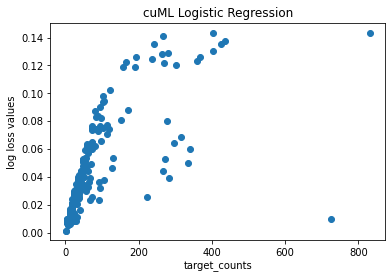

In [132]:
from cuml.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegression

feat_labels = d_tags + poly.get_feature_names(input_features=c_tags) + g_tags
coef_df2 = pd.DataFrame(columns = list(X_df.columns))

# column_names = ["a", "b", "c"]
# coef_df = pd.DataFrame(columns = column_names)
rowval = 0
for i in [256]: # left for further hyperparameter tuning
    from cuml.experimental.preprocessing import StandardScaler
    scaler = StandardScaler()
    #model = LogisticRegression(C = 128, max_iter = 100000, penalty='elasticnet', l1_ratio=1)
    model = LogisticRegression(C = 128, penalty='elasticnet', l1_ratio=1)
    target_counts = []
    logistic_regr_loss_vals = []
    ss_lr.loc[:, train_targets.columns] = 0
    res_lr.loc[:, train_targets.columns] = 0
    res_lr, ss_lr, logistic_regr_loss_vals, coef_df2 = run_score(train_targets, X_df.values, x_test_df.values, res_lr, ss_lr, logistic_regr_loss_vals, coef_df2)
    
plt.scatter(target_counts,logistic_regr_loss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('cuML Logistic Regression')
plt.show()
res_lr.to_pickle('pickles/res_cuml_lr.p')
ss_lr.to_pickle('pickles/ss_cuml_lr.p')